In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import numpy as np

In [2]:
# Enable GPU. Edit → Notebook Settings → Hardware accelerator: GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!unzip -qo dataset.zip -d ./dataset

In [4]:
# Setup the train and test directories
train_dir = 'dataset/train/'
test_dir = 'dataset/test/'

In [5]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

In [6]:
# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [7]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='categorical',
                                                                            shuffle=True) # Shuffle data (default)

Found 4500 images belonging to 3 classes.


In [8]:
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 900 images belonging to 3 classes.


In [9]:
# define model
model = tf.keras.models.Sequential([Conv2D(filters=32, 
                                           kernel_size=3,
                                           activation='relu', 
                                           input_shape=(224, 224, 3)),
                                    Conv2D(64, 3, activation='relu'),
                                    MaxPool2D(2),
                                    Conv2D(128, 3, activation='relu'),
                                    MaxPool2D(2),
                                    Conv2D(256, 3, activation='relu'),
                                    MaxPool2D(2),
                                    Conv2D(512, 3, activation='relu'),
                                    MaxPool2D(2),
                                    Flatten(),
                                    Dropout(0.7),
                                    Dense(2048, activation = 'relu'),
                                    Dense(3, activation='softmax')])

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [11]:
# Check out the layers in our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 256)       2

In [12]:
# Fit the model
history = model.fit(train_data_augmented_shuffled,
                    epochs=30,
                    steps_per_epoch=len(train_data_augmented_shuffled),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/30
141/141 [==============================] - 94s 618ms/step - loss: 1.1251 - accuracy: 0.3584 - val_loss: 1.0872 - val_accuracy: 0.4644
Epoch 2/30
141/141 [==============================] - 86s 607ms/step - loss: 1.0232 - accuracy: 0.4889 - val_loss: 0.8334 - val_accuracy: 0.6878
Epoch 3/30
141/141 [==============================] - 85s 599ms/step - loss: 0.9265 - accuracy: 0.5976 - val_loss: 0.7179 - val_accuracy: 0.7344
Epoch 4/30
141/141 [==============================] - 84s 595ms/step - loss: 0.7514 - accuracy: 0.6971 - val_loss: 0.5569 - val_accuracy: 0.7933
Epoch 5/30
141/141 [==============================] - 85s 599ms/step - loss: 0.6861 - accuracy: 0.7264 - val_loss: 0.5374 - val_accuracy: 0.7956
Epoch 6/30
141/141 [==============================] - 84s 595ms/step - loss: 0.6417 - accuracy: 0.7431 - val_loss: 0.5263 - val_accuracy: 0.8078
Epoch 7/30
141/141 [==============================] - 84s 594ms/step - loss: 0.6225 - accuracy: 0.7589 - val_loss: 0.4945 - val_ac

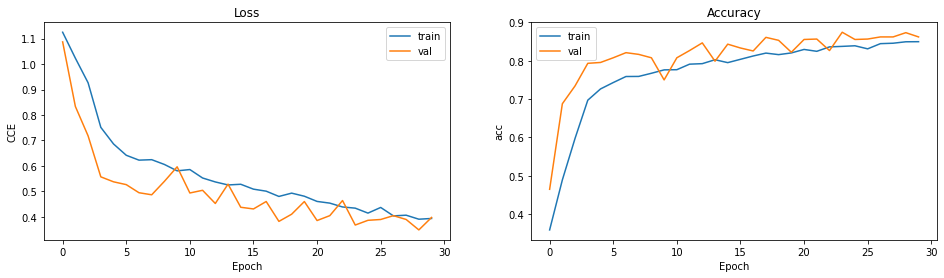

In [13]:
# plot learning curves
plt.figure(figsize=(16,4))

plt.subplot(121)
plt.title('Loss')
plt.xlabel('Epoch'), plt.ylabel('CCE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(122)
plt.title('Accuracy')
plt.xlabel('Epoch'), plt.ylabel('acc')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

plt.show()

In [14]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels
    # but sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

In [15]:
def pred_and_plot(model, filename, class_names):
      """
      Imports an image located at filename, makes a prediction on it with
      a trained model and plots the image with the predicted class as the title.
      """
      # Import the target image and preprocess it
      img = load_and_prep_image(filename)

      # Make a prediction
      pred = model.predict(tf.expand_dims(img, axis=0))

      # Get the predicted class
      pred_class = class_names[pred.argmax()]

      # Plot the image and predicted class
      plt.imshow(img)
      plt.title(f"Prediction: {pred_class}")
      plt.show()

In [16]:
samples_path = ['http://zimbabwebookproject.weebly.com/uploads/3/9/0/2/39029957/food-layer2_1.jpg'
               ,'https://1.bp.blogspot.com/_U3smsd2mIlI/SrdrzZpiCwI/AAAAAAAAAVI/5O1gBNInZb4/s400/chickenbrain.jpg'
               ,'http://birdbreedscentral.com/wp-content/uploads/2015/04/Catalan-Chicken.jpg'
               ,'https://live.staticflickr.com/2931/32835607710_c8182ae7a6_n.jpg'
               ,'https://i.pinimg.com/originals/67/fb/da/67fbda5be89df0eba6d3d61d92a18809.jpg'
               ,'https://live.staticflickr.com/8390/8558308706_7905064e2b.jpg'
               ,'https://furmanagers.com/wp-content/uploads/2019/11/dreamstime_xs_25567360.jpg'
               ,'https://i.pinimg.com/736x/2b/0d/90/2b0d9050873e64340648f25014ff013e.jpg'
               ,'https://softsolder.files.wordpress.com/2010/06/dsc05192-red-squrrel-front.jpg']

In [17]:
class_names = ['chicken', 'sheep', 'squirrel']

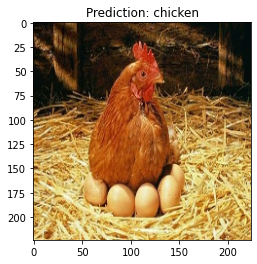

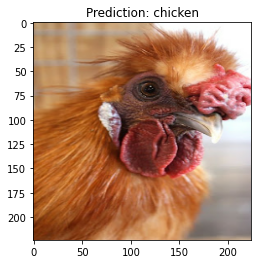

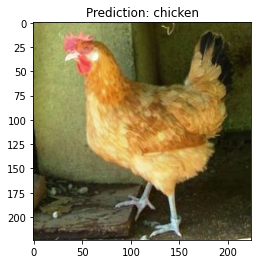

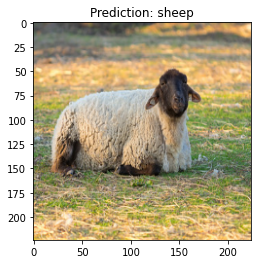

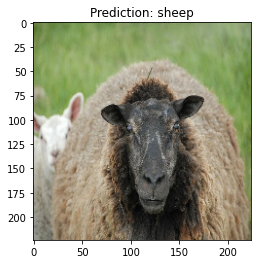

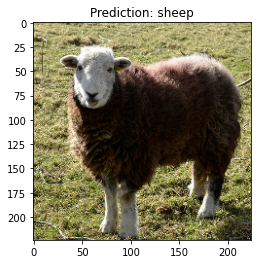

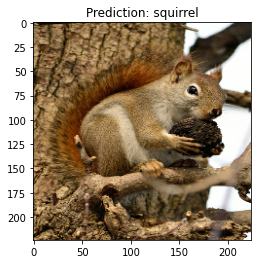

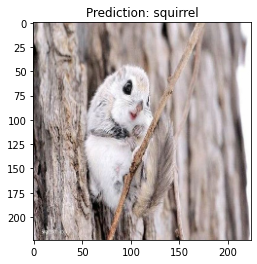

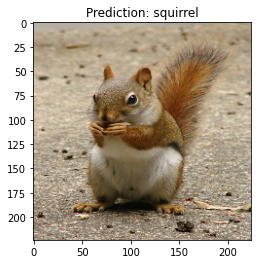

In [18]:
for i,path in enumerate(samples_path):
    img_path = f"./samples/img_{i}.jpg"
    !curl -s {path} --create-dirs -o {img_path}

    pred_and_plot(model, img_path, class_names)